#데이터 : 
-공유자전거 수요 예측 (bike sharing demand) </br>
#데이터 선정 이유 : 
-소비자의 수요에 맞춰 자원을 효과적으로 활용할 수 있다 . </br>
-kaggle competition 자료이므로 모델의 성능을 객관적으로 평가할 수 있다. </br>
-카카오바이크와 같이 실생활과 밀접해 있다.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/MyDrive/bike-sharing-demand-meta/train.csv'
df = pd.read_csv(filename)
print(df.shape)
df.head()

## datetime : 2011-01-01 00:00:00 ~ 2012-12-19 23:00:00
## season : 1~4 => 1: spring, 2: summer, 3:fall, 4: winter
## weather : 1~4 => Clear, Few clouds, Partly cloudy, Partly cloudy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
mask = df['datetime']=='2011-03-19 09:00:00'    ##19일까지밖에없네
df[mask]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1308,2011-03-19 09:00:00,1,0,0,1,17.22,21.21,44,31.0009,35,41,76


In [ ]:
target = 'count'

## 결측치 확인. : (없음.)
[(x, df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()]

# from pandas_profiling import ProfileReport
# # !pip install --upgrade pandas

# # !pip install pandas-profiling[notebook]
# # !pip install -U pandas-profiling      ## update하기.
# report = ProfileReport(df)
# report    ## categorical 한 columns : Type, Method, Regionname, CouncilArea ; (4개)

[]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


145.0


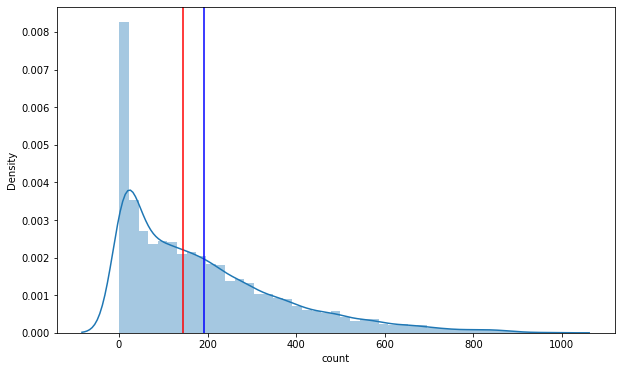

In [ ]:
## target분포 확인
from matplotlib import pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize = (10, 6)) 
sns.distplot(df[target])
plt.axvline(df[target].median(), color='red');
plt.axvline(df[target].mean(), color='blue')
print(df[target].median())

In [ ]:
# np.percentile 사용해 이상치 제거
df = df[(df[target] >= np.percentile(df[target], 0.05)) & 
        (df[target] <= np.percentile(df[target], 99.5))]

In [ ]:
# ## target과 feature간 상관관계 확인.

# df.corr().iloc[:,-1].sort_values(ascending = False)

# for i in df.columns:
#   f, ax = plt.subplots(figsize=(4,4))
#   plt.xlabel(i)
#   ax.scatter(df[i], df[target])

# for i in df.columns:
#   plt.scatter(df[i], df[target])

In [ ]:
# sns.set(style='whitegrid', context='notebook')
# sns.pairplot(df.columns, height=2)

In [ ]:
## 각 column data 확인.
col = pd.Series(df.columns, index=df.columns)
dlte=['count','casual','registered']     ## target 빼고 보기.
col = col.drop(labels=dlte)

for i in col:
  print(i, df[i].unique())

datetime ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ...
 '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season [1 2 3 4]
holiday [0 1]
workingday [0 1]
weather [1 2 3 4]
temp [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3
 10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78
 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7  30.34 31.16 29.52
 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36
 41.  ]
atemp [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455
 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575
 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515 27.275 29.545
 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79
 34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365
 37.88  42.425 43.94  38.635  1.515  0.76   2.275 43.18  44.695 45.455]
humidity [ 81  80  75  86  76  77  72  82  88  87 

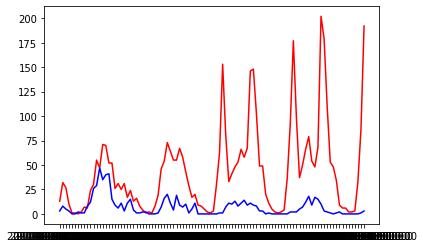

In [ ]:
## casual, registered
plt.plot(df['datetime'][:100], df['registered'][:100], color='r')     ## registered (빨강)
plt.plot(df['datetime'][:100], df['casual'][:100], color='b')         ## casual (파랑)          casual ->registered 등록고객이 늘어나는 추세(증가율은 따로 확인 필요)

In [ ]:
## 시간에 따라 train, test 나누기 (datetime에 맞춰 sort되어 있음.)

train = df.loc[:len(df)*0.8,:]
test = df.loc[len(df)*0.8:,:]
val = train.loc[len(train)*0.8:,:]
train = train.loc[:len(train)*0.8,:]


print(len(df), len(train), len(val), len(test))
print(train)
print(val)
print(test)

10833 6923 1730 2180
                 datetime  season  holiday  ...  casual  registered  count
0     2011-01-01 00:00:00       1        0  ...       3          13     16
1     2011-01-01 01:00:00       1        0  ...       8          32     40
2     2011-01-01 02:00:00       1        0  ...       5          27     32
3     2011-01-01 03:00:00       1        0  ...       3          10     13
4     2011-01-01 04:00:00       1        0  ...       0           1      1
...                   ...     ...      ...  ...     ...         ...    ...
6918  2012-04-06 14:00:00       2        0  ...     240         250    490
6919  2012-04-06 15:00:00       2        0  ...     218         319    537
6920  2012-04-06 16:00:00       2        0  ...     184         352    536
6921  2012-04-06 17:00:00       2        0  ...     172         483    655
6922  2012-04-06 18:00:00       2        0  ...     104         380    484

[6923 rows x 12 columns]
                 datetime  season  holiday  ...  casu

In [ ]:
# 특성공학

def engine(df):
  df = df.copy()

  df['date'] = df['datetime'].apply(lambda x: x.split(' ')[0])
  df['date'] = df['date'].apply(lambda x: x.replace('-',''))
  # df['date'] = df['date'].astype(int)     ## 20110101
  # df['date'].     ## 20110101 =>1, ... 20121231 =>마지막.

  df['hour'] = df['datetime'].apply(lambda x: x.split(' ')[1])    ## 시간
  df['hour'] = df['hour'].apply(lambda x: x.split(':')[0])    ## 분단위 삭제.
  df['hour'] = df['hour'].astype(int)

  df['temp_weighted'] = df['temp']*0.4 + df['atemp']*0.6      ## 다중공선성 방지. (체감온도에 조금더 가중치를 둔 값.)

  df = df.drop(columns=['casual','registered', 'datetime', 'temp', 'atemp','date'], axis=1)   ## multicolinearity 방지
  return df

test1 = test.copy()

train = engine(train)
val = engine(val)
test = engine(test)

In [ ]:
# ## pair plot (시간오래걸림)

# sns.set(style='whitegrid', context='notebook')
# cols = train.columns   ## 혹은 보고싶은 column만 ['~', '~']
# sns.pairplot(train[cols], height=2);

In [ ]:
## X, y split

feature = train.drop(columns=[target]).columns

X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

print(len(df), len(X_train), len(X_val), len(X_test))

10833 6923 1730 2180


In [ ]:
## modeling

# !pip install category_encoders
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_val_score
# from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb

pipe = make_pipeline(
    OrdinalEncoder(),
    # SimpleImputer(strategy='mean'), 
    # StandardScaler(),
    # SelectKBest(f_regression, k=20),
    # RandomForestRegressor(max_depth=10)
    xgb.XGBRegressor(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2)
    # DecisionTreeRegressor()
    # LogisticRegression()
)

# model = xgb.XGBRegressor(n_estimators=200, random_state=2, n_jobs=-1, max_depth=7, learning_rate=0.2)
# eval_set = [(X_train, y_train), 
#             (X_val, y_val)]
# model.fit(X_train, y_train, 
#           eval_set=eval_set,
#           eval_metric='error', ## rmse for regression
#           early_stopping_rounds=50)

pipe.fit(X_train, y_train)

         
print('검증 정확도: ', pipe.score(X_val, y_val))

y_test_pred = pipe.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))

[07:53:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
검증 정확도:  0.7018678561252992
90.59550144479635


In [ ]:
pipe.named_steps

In [ ]:
rf = pipe.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = len(train.columns)
plt.figure(figsize=(8,n/2))
plt.title(f'feature {n-1} importances')
importances.sort_values()[-n:].plot.barh();

In [ ]:
## 기준모델.
y_test_base = np.empty(len(y_test))
y_test_base.fill(y_test.median())   ## 회귀
# y_test_base.fill(int(test[target].mode()))        ##분류
y_test_base = pd.DataFrame(y_test_base, columns=[target])

print(y_train.median(), y_test.median())
print("기준모델 : MSE ", mean_absolute_error(y_test, y_test_base), ", R2 score :", pipe.score(X_test, y_test_base))     ## 기준모델(y_test.median)과 실제값 사이에 163.45 MSE 차이남.

y_test_pred = pipe.predict(X_test)
print("예측모델 : MSE ", mean_absolute_error(y_test, y_test_pred), ", R2 score :", pipe.score(X_test,y_test))     ## 모델은 67.86 MSE 차이.  logarithmic 해도 68.766인데...

In [ ]:
# def date(df):
#   df = df.copy()
#   df['date'] = df['date'].astype(str)     ## 20110101
#   return df

# date(X_train)
# date(X_val)
# date(X_test)
# date(train)
# date(val)
# date(test)

In [ ]:
## test 100개 샘플의 pred 그래프
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['count'])
y_test_pred_df = y_test_pred_df.assign(datetime=test1['datetime'].values)

n=100
plt.figure(figsize=(15,6))
plt.plot(y_test_pred_df['datetime'][:n], test['count'][:n], color='b')                ## y_test 실제값 (파랑)
plt.plot(y_test_pred_df['datetime'][:n], y_test_pred_df['count'][:n], color='r')      ## y_test 예측값 (빨강)